# Example predictions of field particle correlation signatures
Here, we predict the signatures found in Howes 2017 (a kinetic alfven wave experiencing landau damping). 

Please, open a terminal, navigate to the install directory, make PLUME (run 'make all'), and run all the cells in this notebook to verify that everything is working correctly.

This notebook and related libraries serve as wrappers that make and call input files for plume using (os.system('./plume.e *flnm*.in >> outlog') One can also use ./plume.e *flnm*.in to run plume.

If things are not behaving as expected, please check the outlog, where all plume output is saved when using this notebook.

*** Please check outlog for any warnings that PLUME might create and write to the outlog. These warnings *will not* be presented here in any way. Using this notebook, one may input parameters that allows the solver to run, but violates assumptions made when deriving the equations used by the solver ***

Warning: these scripts have only been tested using two species

## Load libraries, and enter parameters

In [2]:
import linfpclib.linfpc as lfpc
import linfpclib.linfpcplot as lp

import os
import numpy as np

In [2]:
#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

<module 'linfpclib.linfpcplot' from '/Users/work/Documents/Research/LinKinTheory/LinFPCPaperAndData/PLUME/linfpclib/linfpcplot.py'>

In [3]:
filetag = 'howes2017' #this will be used to name all output files and folders
plumeinput = lfpc.plume_input(filetag)

In [4]:
betap=1
kperp=1.3
kpar=.05 #not specified in paper but when kpar << 1, exact number is not needed as dynamics don't change much in this regime
vtp=1.0E-4
nspec=2
nscan=1
option=1
nroot_max=20
use_map=True
writeOut=True

plumeinput.set_params(betap,kperp,kpar,vtp,nspec,nscan,option,\
                    nroot_max,use_map,writeOut)

In [5]:
#make ions
tauS=1.0
muS=1.0
alphS=1.0
Qs=1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 1)

No species found, creating first species...


In [6]:
#make elecs
tauS=1
muS=1836
alphS=1.0
Qs=-1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 2)

Appending species to list. Total species is now  2


In [7]:
#given the fixed above parameters, PLUME solves the dispersion relation for values over the range of omega
#and gamma given below. It initializes a grid (either log spaced or evenly spaced) and does it's best to find 
#all roots in this range. For each grid point, gradient descent is used to try and find a nearby solution.
#Sometimes this results in no found root. Sometimes roots are found outside the sweep range 
#(both close to the range, and very far from it)
loggridw=False
omi=-1.0E-02
omf=1.0E-0
gami=-2.0E-01
gamf=2.0E-01
positive_roots=True
plumeinput.set_maps(loggridw,omi,omf,gami,gamf,positive_roots)

In [8]:
inputfldr= 'input/'+filetag+'/' #folder where all generated input files will be placed
cmd = 'mkdir '+inputfldr
print(cmd)
os.system(cmd) #256 exit code means folder already exits, 0 means it sucessfully made the folder



mkdir input/howes2017/


mkdir: input/howes2017/: File exists


256

## Find roots

In [9]:
roots = lfpc.compute_roots(plumeinput,inputfldr+'roots',filetag)

OVERWRITING OPTION; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
mkdir data/howes2017
./plume.e input/howes2017/roots.in >> outlog


mkdir: data/howes2017: File exists


Reading roots from  data/howes2017/dispersion_howes2017.roots


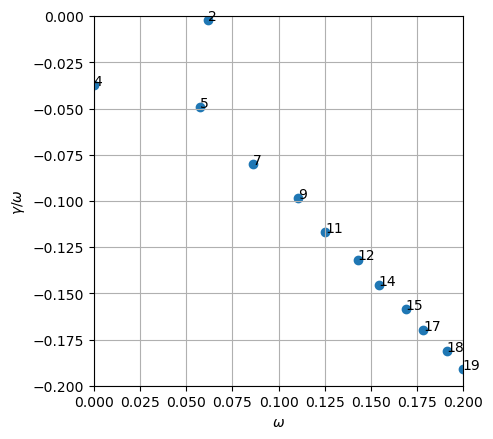

In [10]:
import matplotlib.pyplot as plt
oms = [rt.real for rt in roots]
gams = [rt.imag for rt in roots]
lbls = [_i for _i in range(0,len(oms))]

plt.figure()
plt.scatter(oms,gams)
plt.xlim(0,.2)
plt.ylim(-.2,0)
for _i, txt in enumerate(lbls):
    plt.gca().annotate(txt, (oms[_i], gams[_i]))
plt.gca().set_aspect('equal')
plt.grid()
plt.xlabel(r"$\omega$") #normalized as in PLUME 
plt.ylabel(r"$\gamma / \omega$")
plt.show()

## Select root to compute dispersion relation as a function of selected variable

In [11]:
rootidx = 2
roots[rootidx] #later we show that this is the alfven root

(0.061719-0.0022112j)

In [12]:
importlib.reload(lfpc)
sweepvarkey = 'kperp'
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50)

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
./plume.e input/howes2017/sweepsweep1.in >> outlog
Rewriting file...
./plume.e input/howes2017/sweepsweep2.in >> outlog
Loading  data/howes2017/sweepsweep1_kperp_1300_100000.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Loading  data/howes2017/sweepsweep2_kperp_1300_100.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Combining data and returning as 1 sweep...


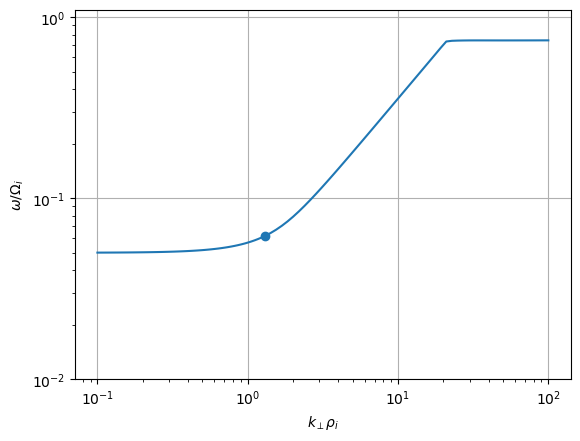

In [13]:
#'verify' that we have the alfven branch solution 
#(often more analysis will be needed, but sometimes one can use intuition to select the correct branch)
#(for example, here we know it is the alfven branch solution as the wave goes dispersive at kperprhoi~1)
#(an b/c it evenutally 'hits a resonance and flattens out')
#(later this is verified by getting an accurate FPC prediction )
plt.figure()
xplot = sweep['kperp']
yplot = sweep['w']
plt.loglog(xplot,yplot)
plt.scatter(plumeinput.params['kperp'],roots[rootidx].real)
plt.xlabel(r"$k_\perp \rho_i$")
plt.ylabel(r"$\omega / \Omega_i$")
plt.ylim(0.01,1.1)
plt.grid()
plt.show()

## Predict FPC signature of selected root

In [14]:
vperpmin = .05
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .1
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv)

In [15]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need this bools
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [16]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Forcing input file to use root as initial guess
Rewriting file...
mkdir data/howes2017
./plume.e input/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [17]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])

Opening data/howes2017/fpc.cpar.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cperp.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cpar.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)
Opening data/howes2017/fpc.cperp.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)


In [18]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

In [19]:
importlib.reload(lp)

lp.plotlinfpcv2(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

Plotting interval...
False
plotting linear scale!
Saving figure to figures folder!


In [20]:
lp.plotlinfpcv2(iondatacperp,filetag+'/'+filetag+'cperp.png')

False
plotting linear scale!
Saving figure to figures folder!


In [21]:
lp.plotlinfpcv2(elecdatacpar,filetag+'/'+filetag+'elec.png')

False
plotting linear scale!
Saving figure to figures folder!


In [22]:
lp.plotlinfpcv2(elecdatacperp,filetag+'/'+filetag+'eleccperp.png')

False
plotting linear scale!
Saving figure to figures folder!


## Predict damping contribution by mechanisms 

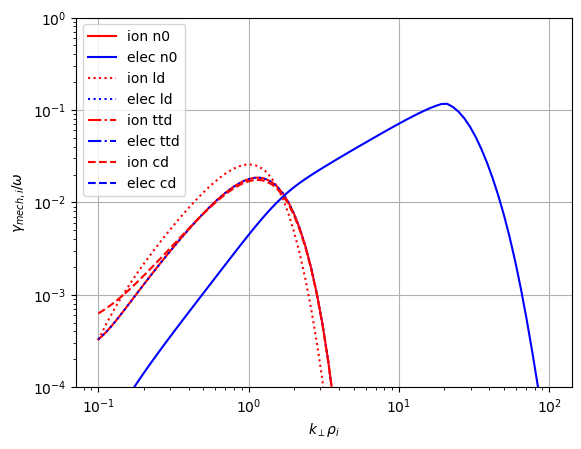

In [23]:
#plot estimated contributes due to landau damping, transit time damping, and cyclotron damping (n0 is 'total')
import numpy as np
plt.figure()
plt.plot(sweep['kperp'],sweep['ps1'],color='red')
# plt.plot(sweep['kperp'],sweep['ps2'],color='blue')

# plt.plot(sweep['kperp'],sweep['p1n0']+sweep['p1ld']+sweep['p1ttd']+sweep['p1cd'])

plt.loglog(sweep['kperp'],sweep['p1n0'],color='red',label='ion n0',ls='-')
plt.loglog(sweep['kperp'],sweep['p2n0'],color='blue',label='elec n0',ls='-')
plt.loglog(sweep['kperp'],sweep['p1ld'],color='red',label='ion ld',ls=':')
plt.loglog(sweep['kperp'],sweep['p2ld'],color='blue',label='elec ld',ls=':')
plt.loglog(sweep['kperp'],sweep['p1ttd'],color='red',label='ion ttd',ls='-.')
plt.loglog(sweep['kperp'],sweep['p2ttd'],color='blue',label='elec ttd',ls='-.')
plt.loglog(sweep['kperp'],sweep['p1cd'],color='red',label='ion cd',ls='--')
plt.loglog(sweep['kperp'],sweep['p2cd'],color='blue',label='elec cd',ls='--')

plt.xlabel(r"$k_\perp \rho_i$")
plt.ylabel(r"$\gamma_{mech,i}/\omega$")
plt.ylim(.0001,1)
plt.legend()
plt.grid()
plt.show()

## Double sweep over kperp and kpar

In [24]:
importlib.reload(lfpc)
importlib.reload(lp)
import copy
tempparams = copy.deepcopy(plumeinput.params)

doublesweep = {}
nsamps = 50
for _key in sweep.keys(): 
    doublesweep[_key] = np.zeros((len(sweep['kperp']),2*nsamps+2)) #2*nsamps+1 as 'make_sweeps_that_branch_from_params' returns 2*nsamps+2 samples

_kperpidx = 0
for _kperpval in sweep['kperp']:
    sweepvarkey = 'kpar'
    sweepmin = np.min(sweep['kperp'])
    sweepmax = np.max(sweep['kperp'])
    roottemp = sweep['w'][_kperpidx]
    plumeinput.params['kperp']= np.round(_kperpval,3)
    inputflnm = inputfldr+'sweeptemp'
    outputname = 'sweeptemp'
    sweeptemp = lfpc.make_sweeps_that_branch_from_params(plumeinput,sweepvarkey,sweepmin,sweepmax,roottemp,inputflnm,outputname,outlog='outlog',nsamps=nsamps,verbose=False)
    for _key in sweep.keys():
        doublesweep[_key][_kperpidx,:] = sweeptemp[_key][:]
    _kperpidx += 1 
    
for _key in sweep.keys():
    doublesweep[_key] = np.asarray(doublesweep[_key])
    
plumeinput.params = tempparams

/var/folders/kh/bvrytszs4gdg3r5ctz6_yqf40000gp/T/ipykernel_26915/1615542166.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = plt.pcolormesh(Xplot,Yplot,Zplot,norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=Zplot.min(), vmax=Zplot.max()),cmap='coolwarm')


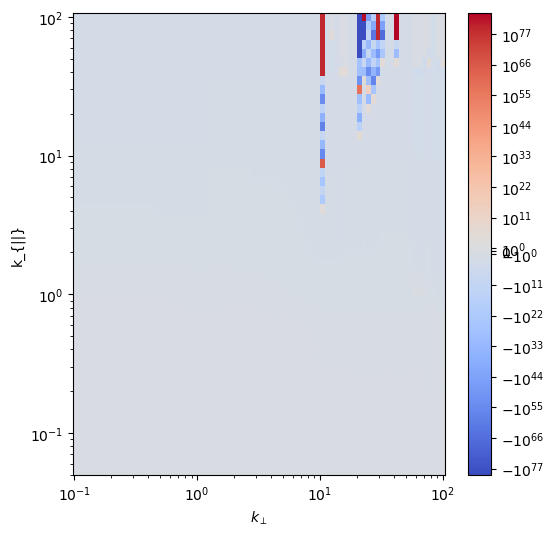

In [25]:
import matplotlib.colors as colors

Xplot = doublesweep['kperp']
Yplot = doublesweep['kpar']
Zplot = doublesweep['g']

plt.figure(figsize=(6,6))
plt.xscale("log")
plt.yscale("log")
im = plt.pcolormesh(Xplot,Yplot,Zplot,norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=Zplot.min(), vmax=Zplot.max()),cmap='coolwarm')
clrbar = plt.colorbar(im, ax=plt.gca())#,format='%.1e')
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"k_{||}")
plt.show()

# Print outlog

The wrapper outputs all statements from the program to the 'outlog' file. Note that output from new plume.e will be concatenated onto the end of the file. It is important that the user check this log for any warning or error messages!

In [3]:
os.system('cat outlog')

-=-=-=-=-=-=-=-=-=-
Root Search:
-=-=-=-=-=-=-=-=-=-
Global Plasma Parameters:
k_perp rho_p   =   0.100000E-01
k_par  rho_p   =   0.400000    
Beta_p         =    1.00000    
vtp/c          =   0.100000    
-=-=-=-=-=-=-=-=-=-
Parameters for Species :  1
T_||p/T_||s =       1.00000    
m_p/m_s =           1.00000    
T_perp/T_par|s =    1.00000    
q_p/q_s =           1.00000    
n_s/n_p =           1.00000    
v_drift s/c =       0.00000    
-=-=-=-=-=-=-=-=-=-
Parameters for Species :  2
T_||p/T_||s =       1.00000    
m_p/m_s =           100.000    
T_perp/T_par|s =    1.00000    
q_p/q_s =          -1.00000    
n_s/n_p =           1.00000    
v_drift s/c =       0.00000    
-=-=-=-=-=-=-=-=-=-
Searching over:
om  \in [-1.000E-02, 1.000E+00]
gam \in [-2.000E-01, 2.000E-01]
-=-=-=-=-=-=-=-=-=-
 6  possible local minima found
ir =    0    ii =  128
   -1.0000E-02    2.0000E-01
ir =  128    ii =  128
    1.0000E+00    2.0000E-01
ir =   65    ii =   64
    5.0289E-01    0.0000E+00
ir = 

0

  32    ii =   57
    2.4250E-01   -2.1875E-02
ir =    0    ii =    0
   -1.0000E-02   -2.0000E-01
ir =   77    ii =    0
    5.9758E-01   -2.0000E-01
Refining roots
Dispersion Solutions 
  1    6.6049E+05   -8.1612E+05
  2    1.6209E+02    5.7547E-08
  3    5.0248E-01   -9.4091E-05
  4    2.4340E-01   -2.1884E-02
  5   -5.0248E-01   -9.4091E-05
  6    5.9504E-01   -2.8532E-01
  7    0.0000E+00    0.0000E+00
  8    0.0000E+00    0.0000E+00
  9    0.0000E+00    0.0000E+00
 10    0.0000E+00    0.0000E+00
 11    0.0000E+00    0.0000E+00
 12    0.0000E+00    0.0000E+00
 13    0.0000E+00    0.0000E+00
 14    0.0000E+00    0.0000E+00
 15    0.0000E+00    0.0000E+00
 16    0.0000E+00    0.0000E+00
 17    0.0000E+00    0.0000E+00
 18    0.0000E+00    0.0000E+00
 19    0.0000E+00    0.0000E+00
 20    0.0000E+00    0.0000E+00
 Predicting FPC (cart coords)...
Input for Root 1:   2.4340E-01 -2.1884E-02
Dispersion Solutions 
  1    2.4340E-01   -2.1884E-02
 Assuming data folder already exists...
 a